# CX Machine Translation services usage analysis

**Krishna Chaitanya Velaga, Data Scientist III, Wikimedia Foundation**

**Last Update: 9 November 2023**

[Ticket](https://phabricator.wikimedia.org/T338606) | [Codebase](https://github.com/wikimedia-research/machine-translation-service-analysis)

<font color='blue'>**Note**</font><br>This notebook has charts generated using [Plotly](https://plotly.com/python/), which may not be visible or appear broken when statically rendered (such as on GitHub or GitLab).<br>➡ Please [follow this link](https://nbviewer.org/github/wikimedia-research/machine-translation-service-analysis-2022/blob/main/mt_service_comparison_Nov2023_update.ipynb) to view and interact with the notebook.

# Table of Contents

1. [Purpose](#Purpose)
2. [Methodology](#Methodology)
3. [Summary](#Summary)
4. [Overall usage across all languages](#Overall-usage-across-all-languages)
    * [YoY comparision](#YoY-comparision)
5. [Daily published translations](#Daily-published-translations)
6. [Usage by language pair](#Usage-by-language-pair)
    * [Languge pairs where an optional service was used more or close to the default](#Languge-pairs-where-an-optional-service-was-used-more-or-close-to-the-default)
    * [Usage at each target language](#Usage-at-each-target-language)
7. [Percent machine translation content is modified](#Percent-machine-translation-content-is-modified)
8. [Deletion rates by MT service](#Deletion-rates-by-MT-service)    
9. [YoY service usage comparision, by language](#YoY-service-usage-comparision)

# Purpose
Content translation supports multiple machine translation services.  When multiple options are available for a language, even if one is provided by default, users can use a different service. [See default configuration](https://www.mediawiki.org/wiki/Help:Content_translation/Translating/Initial_machine_translation?useskin=vector-2022#Machine_translation_availability) and [languages supported](https://www.mediawiki.org/wiki/Help:Content_translation/Translating/Initial_machine_translation?useskin=vector-2022#Machine_translation_availability) files for details on all available language pairs and defaults. 

The purpose of the report is to understand the usage of MT services across various languages, and if needed inform changes to default service provided on certain language pairs. The previous iterations of the report have been run in May 2022 and later again in October 2022, to track changes due to [T309266](https://phabricator.wikimedia.org/T309266), [T307970](https://phabricator.wikimedia.org/T307970), and [T308248](https://phabricator.wikimedia.org/T308248). 

In this report, along with overall usage, we are specifically interested in the [MinT](https://www.mediawiki.org/wiki/MinT), which has exposed several translation models such as NLLB-200 and Opus to many languages.

# Methodology

For each machine translation service, we compared the following:
* Percent of translations published by each machine translation service:
    * Overall across all languages
    * Daily usage trends
    * Usage at each Language Pair (Source - Target)
    * Most frequently used service for each target Language
* Percent each machine translation service was modified by users
* Percent of articles created with each machine translation service that were deleted
* YoY comparision of service usage by language pair

Data comes from the following sources:
* [cx_corpora table](https://www.mediawiki.org/wiki/Extension:ContentTranslation/cx_corpora_table)
* [cx_translations table](https://www.mediawiki.org/wiki/Extension:ContentTranslation/cx_translations_table)

**All published translations from from August to October 2023 were considered for analysis.**

# Summary
**Overall usage**<br>
* Google Translate, which can be used to translate into all available languages except English, has been used for majority of the translations (80%) of the published translations across all language pairs.
* MinT (Machine in Translation) which is a Wikimedia Foundation hosted open-source machine translation service, is now the second most used translation service accounting for 8% percent of all published translations. 
* No machine translation was used (scratch) for 6% of the published translations.

**YoY comparison**<br>*We compared the period of current analysis (August to October 2023) to the same period last year (August to October 2022) to observe changes in service usage.*
* The most significant change has been MinT now being the second most used translation service.
* Although Google is still the most used service, it's usage reduced by 2 percent points (82.72% to 80.28%).
* There has been slight increase (2 percent points; 3.87% to 5.96%) in percentage of translation that used no MT service (scratch).
* While Apertium's usage increased slightly, Yandex's usage decreased slightly.

**Language pairs where an optional service was used more or close to the default**<br>*having at least five published translations*
* There are 26 language pairs where an optional service was used more or close to the default.
* In 50% of the cases, largely where Google was the default service, there are substantial number of translations where no MT service was used (scratch).
* In 25% of the cases, Google was used more than the default service.
* Although, MinT is the default for en-zu, Google was used for 96% of the translations.
* For en-ku, en-st, & ms-simple, MinT was used more than the default service.

**Percentage of MT content modified by the user**
* Majority of the translations across all MT services were modified at least 10% during publication.
* MinT has higher percentage slightly modified content compared to other services: 37% of the translations were modified less than 10%, and 93% of the all translations were modified less than 50% by users.
* 25% of the translations published using Apertium, more than 50% of the content was modified, which is highest among all services

**Deletion rates by MT service**
* Across all languages, MinT has lowest percentage of articles that were deleted (1.72%), and compared to all other services, it has the highest percent of translations modified under 10%, indicating that the modifications rates for this machine translations service are a signal of good machine translation quality.
* Yandex and Google are the top services with higher deletion rates than the rest, 6.24% and 5.21% respectively.
* About 4% of the articles translated without support of any MT service, were deleted.

# imports and functions

In [1]:
import pandas as pd
import duckdb
import numpy as np
import warnings

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

import plotly.express as px
import plotly.graph_objects as go
import plotly.subplots as sp
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
import kaleido

from IPython.display import display_html
from IPython.display import display, HTML

In [2]:
init_notebook_mode(connected=True)

pd.options.display.max_columns = None
pd.options.display.max_rows = 100

bold = '\033[1m'
end = '\033[0m'
underline = '\033[4m'

# max width for plotly charts
iplot_width = 950

# always show options bar
iplot_config = {'displayModeBar': True}

In [3]:
# prints a string at center of the output, bold if needed
def pr_centered(content, bold=False):
    if bold:
        content = f"<b>{content}</b>"
    
    centered_html = f"<div style='text-align:center'>{content}</div>"
    
    display(HTML(centered_html))

# format column as a percentage in a dataframe
def format_percent(column, df):
    return df[column].map('{:.2%}'.format)

# display dataframes horizontally with title for each
def display_h(frames, space=100):
    html = ""
    
    for key in frames.keys():
        html_df =f'<div>{key} {frames[key]._repr_html_()}</div>'
        html += html_df
        
    html = f"""
    <div style="display:flex; justify-content: space-evenly;">
    {html}
    </div>"""
    
    display_html(html, raw=True)

In [4]:
# connect to database
conn = duckdb.connect('data_gathering/secrets/mt_data.db')

In [5]:
def query(query_string, df=False, conn=conn):
    if df==True:
        return conn.sql(query_string).df()
    else:
        return conn.sql(query_string).show()

In [6]:
# conn.close()

# Overall-usage-across-all-languages

In [6]:
# get 2023 overall data
mt_compare_overall_2023 = query("""
WITH
    base AS (
        SELECT 
            mt_service,
            COUNT(DISTINCT translation_id) AS n_translations
        FROM 
            mt_logs
        WHERE
            translation_start_time >= '2023-08-01' AND
            translation_start_time <= '2023-10-31'
        GROUP BY
            mt_service
        ORDER BY
            n_translations DESC)


SELECT
    mt_service AS 'Machine translation service',
    n_translations AS 'Number of Translations',
    n_translations / SUM(n_translations) OVER () AS 'Percent of all published translations'
FROM
    base
""", True)

In [7]:
mt_compare_overall_2023_pr = mt_compare_overall_2023.copy()
mt_compare_overall_2023_pr['Percent of all published translations'] = format_percent('Percent of all published translations', mt_compare_overall_2023_pr)

In [8]:
pr_centered('Published translations by machine translations service across all language pairs', True)
pr_centered('August to October 2023')
display_h({
    '':mt_compare_overall_2023_pr.set_index('Machine translation service')
})

,Number of Translations,Percent of all published translations
Machine translation service,,
Google,63335,80.28%
MinT,6300,7.99%
scratch,4704,5.96%
Apertium,2144,2.72%
Yandex,1505,1.91%
Elia,865,1.10%
LingoCloud,38,0.05%


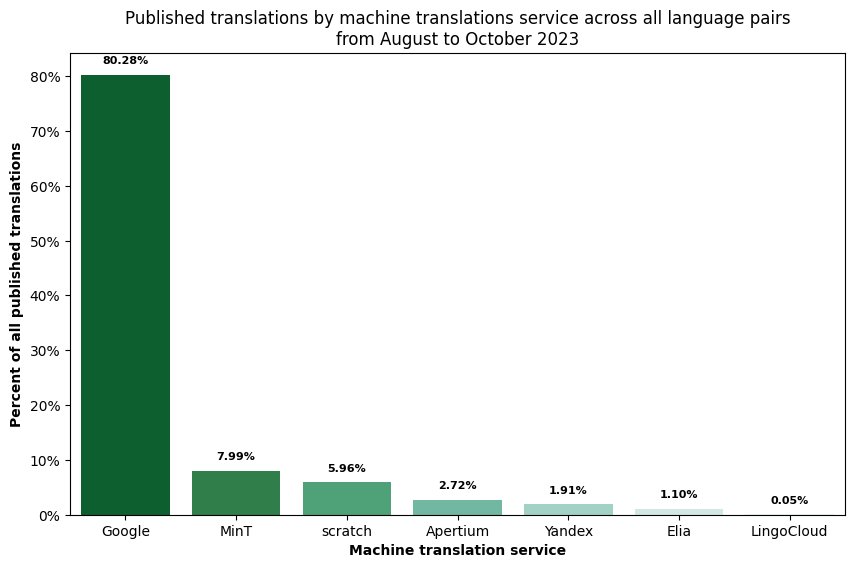

In [9]:
# bar chart
mt_compare_overall_2023['Percent of all published translations'] *= 100

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=mt_compare_overall_2023, x='Machine translation service', y='Percent of all published translations', palette="BuGn_r")

# format y-axis as percetange
ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))

# add data labels for bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=8, fontweight='bold', color='black', 
                xytext=(0, 10), textcoords='offset points')

# plot and axes titles
plt.title("Published translations by machine translations service across all language pairs\nfrom August to October 2023")
plt.xlabel("Machine translation service", fontweight='bold')
plt.ylabel("Percent of all published translations", fontweight='bold')

plt.show()

## YoY-comparision

In [10]:
# get 2022 overall data
mt_compare_overall_2022 = query("""
WITH
    base AS (
        SELECT 
            mt_service,
            COUNT(DISTINCT translation_id) AS n_translations
        FROM 
            mt_logs
        WHERE
            translation_start_time >= '2022-08-01' AND
            translation_start_time <= '2022-10-31'
        GROUP BY
            mt_service
        ORDER BY
            n_translations DESC)


SELECT
    mt_service AS 'Machine translation service',
    n_translations AS 'Number of Translations',
    n_translations / SUM(n_translations) OVER () AS 'Percent of all published translations'
FROM
    base
""", True)

In [11]:
mt_compare_overall_2022_pr = mt_compare_overall_2022.copy()
mt_compare_overall_2022_pr['Percent of all published translations'] = format_percent('Percent of all published translations', mt_compare_overall_2022)

pr_centered('Published translations by machine translations service across all language pairs', True)
display_h({
    'August to October 2022': mt_compare_overall_2022_pr.set_index('Machine translation service'),
    'August to October 2023': mt_compare_overall_2023_pr.set_index('Machine translation service')
})

,Number of Translations,Percent of all published translations
Machine translation service,,
Google,69824,82.72%
NLLB-200,5534,6.56%
scratch,3270,3.87%
Yandex,2965,3.51%
Apertium,1576,1.87%
Elia,978,1.16%
OpusMT,214,0.25%
LingoCloud,25,0.03%
MinT,19,0.02%


## Daily published translations
Translations published per day by each MT service were reviewed to identify any sudden increases or decreases in usage and to determine if those changes corresponded to deployments or setting changes that may have impacted MT availability.

In [12]:
# get daily translations count
mt_daily = query("""
WITH base AS (
    SELECT 
        mt_service,
        translation_start_time AS date,
        translation_id
    FROM 
        mt_logs
    WHERE
        translation_start_time >= '2022-08-01' 
        AND translation_start_time <= '2023-10-31'
        AND mt_service != 'original')

SELECT
    date,
    mt_service,
    COUNT(DISTINCT translation_id) AS n_translations
FROM
    base
GROUP BY
    date,
    mt_service
""", True)

In [13]:
# 2023 daily translations count
warnings.filterwarnings('ignore')
mt_2023_daily = (
    mt_daily
    .query("'2023-04-01' <= date <= '2023-10-31'")
    .replace([np.inf, -np.inf], np.nan)
    .dropna(subset=['date', 'n_translations'])
)

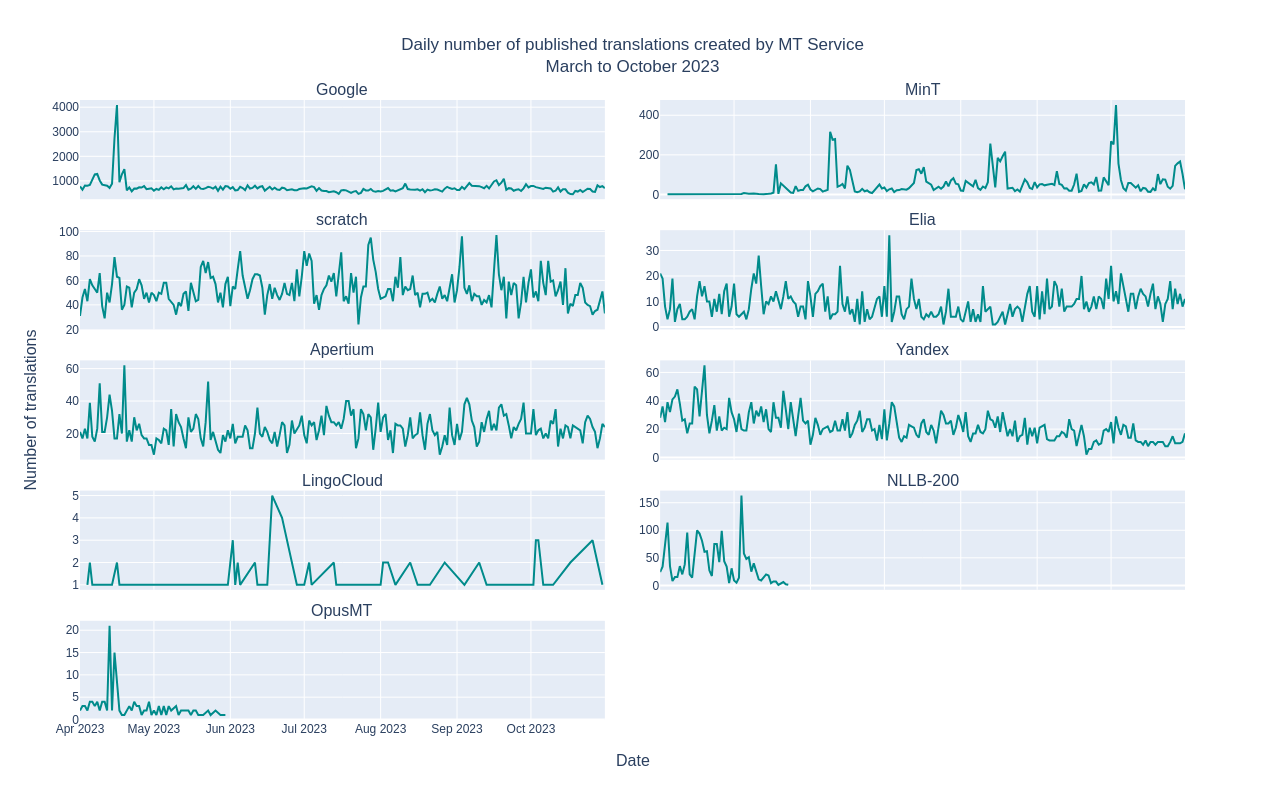

In [14]:
# unique mt services
mt_services = mt_2023_daily.mt_service.unique()

# subplots
fig = sp.make_subplots(rows=5, cols=2, 
                       shared_xaxes=True, 
                       subplot_titles=mt_services,
                       x_title='Date',
                       y_title='Number of translations',
                       vertical_spacing=0.05, 
                       horizontal_spacing=0.05)

for i, mt_service in enumerate(mt_services):
    row, col = divmod(i, 2)
    service_data = mt_2023_daily.query(f"mt_service == '{mt_service}'").sort_values('date')

    fig.add_trace(go.Scatter(x=service_data['date'], 
                             y=service_data['n_translations'], 
                             mode='lines',
                             name=mt_service,
                             showlegend=False, 
                             line=dict(color='DarkCyan')),
                  row=row+1, col=col+1)

fig.update_xaxes(range=[mt_2023_daily['date'].min(), pd.to_datetime('2023-10-31')])
fig.update_layout(title_text="Daily number of published translations created by MT Service<br>March to October 2023",
                  title_x=0.5, height=800, width=iplot_width)

iplot(fig, config=iplot_config)

**Summary**
* With the deployment of MinT, around May/June 2023, NLLB-200's and OpusMT's direct usage ended as these are now integrated into MinT.
* As MinT deployments happened in stages, spikes can be seen at various instances when the MinT was enabled for new language pairs.
* The huge spike in Google's usage in April 2023, is specifically due to increased activity Uzbek Wikipedia, likely due to a translation campaign.
* Compared to 2022, the median number of daily translations from scratch, increased from 34 to 49.

## Median number of daily translations, by service

In [15]:
def daily_median(start_dt, end_dt, df=mt_daily):
    return (
        df    
        .query(f"""'{start_dt}' <= date <= '{end_dt}'""")
        .groupby('mt_service')
        .agg({'n_translations': 'median'})
        .astype(int)
        .sort_values('n_translations', ascending=False)
        .reset_index()
        .rename({
            'mt_service': 'Service', 
            'n_translations': '# Translations'
        }, axis=1)
        .set_index('Service')
    )

In [16]:
pr_centered('Number of Daily Translations (Median)', True)
display_h({
    'August to October 2022': daily_median('2022-08-01', '2022-10-31'),
    'April to June 2023': daily_median('2023-04-01', '2023-06-30'),
    'August to October 2023': daily_median('2023-08-01', '2023-10-31')
})

,# Translations
Service,
Google,719
scratch,33
Yandex,27
NLLB-200,20
Apertium,16
Elia,8
OpusMT,3
LingoCloud,1
MinT,1


# Usage-by-language pair
* The number and percentage of publications by each machine translation service at each language pair (i.e., source language and target language) were reviewed. 
* Due to the large combination of language pairs, the data was saved to a [Google Spreadsheet](https://docs.google.com/spreadsheets/d/1ChaLHO8XjiH1_b0ueDR8RAyiBwUpRUzAPssYocxFz_A/edit?usp=sharing) to easily filter and identify the percentage of publications by language pair for each machine translation service.

In [17]:
# get mt usage by language pair
mt_by_langpair = query("""
WITH
    base AS (
        SELECT
            source_language,
            target_language,
            mt_service,
            COUNT(DISTINCT translation_id) AS n_translations
        FROM 
            mt_logs
        WHERE
            translation_start_time >= '2023-08-01' AND
            translation_start_time <= '2023-10-31'
        GROUP BY
            source_language,
            target_language,
            mt_service
        ORDER BY
            source_language,
            target_language,
            n_translations)

SELECT
    *,
    n_translations / SUM(n_translations) OVER (PARTITION BY source_language, target_language) AS pct_translations
FROM
    base
""", True)

In [33]:
mt_by_langpair.to_csv('data_gathering/secrets/mt_usage_langpair.tsv', sep='\t', index=False)

## Languge-pairs-where-an-optional-service-was-used-more-or-close-to-the-default

In [18]:
# get default service information
mt_defaults = query("""
WITH
    base AS (
        SELECT
            *,
            source_language||'-'||target_language AS pair
        FROM
            mt_by_langpair mt
        )
    
SELECT 
    b.* EXCLUDE(mt_service),
    b.mt_service AS service_used,
    dfs.service AS default_service
FROM 
    base b
    JOIN mt_defaults dfs
    ON b.pair = dfs.pair
WHERE
    service_type = 'default_mt'
""", True)

In [19]:
# having at least five published translations
# a service account for at least 25% of the translations for a given language pair
mt_optional_services_used_more = mt_defaults[
    (mt_defaults['service_used'] != mt_defaults['default_service']) & 
    (mt_defaults['pct_translations'] > 0.25) &
    (mt_defaults['n_translations'] > 5)
]

mt_optional_services_used_more_pr = mt_optional_services_used_more.copy()
mt_optional_services_used_more_pr = (
    mt_optional_services_used_more_pr
    .rename(columns={
        'source_language': 'Source',
        'target_language': 'Target',
        'n_translations': '# Translations',
        'pct_translations': '% of Translations',
        'service_used': 'MT service used',
        'default_service': 'Default service'
    })
    .set_index(['Default service', 'Source']))

mt_optional_services_used_more_pr.sort_values(['Default service', '% of Translations'], ascending=False, inplace=True)
mt_optional_services_used_more_pr['% of Translations'] = format_percent('% of Translations', mt_optional_services_used_more_pr)

In [20]:
pr_centered('Languge pairs where an optional service was used more or close to the default', True)
pr_centered('(having at least five published translations)')
display_h({
    '': mt_optional_services_used_more_pr
})

Target 
 # Translations 
 % of Translations 
 pair 
 MT service used 
 
 
 Default service 
 Source 
 
 
 
 
 
 
 
 
 
 MinT 
 en 
 zu 
 55 
 96.49% 
 en-zu 
 Google 
 
 
 Google 
 en 
 ja 
 57 
 100.00% 
 en-ja 
 scratch 
 
 
 tr 
 en 
 7 
 100.00% 
 tr-en 
 scratch 
 
 
 en 
 de 
 16 
 100.00% 
 en-de 
 scratch 
 
 
 ar 
 en 
 31 
 93.94% 
 ar-en 
 scratch 
 
 
 de 
 lb 
 29 
 90.62% 
 de-lb 
 Yandex 
 
 
 fa 
 en 
 45 
 75.00% 
 fa-en 
 scratch 
 
 
 he 
 en 
 27 
 75.00% 
 he-en 
 scratch 
 
 
 uk 
 be 
 52 
 72.22% 
 uk-be 
 Yandex 
 
 
 en 
 st 
 9 
 60.00% 
 en-st 
 MinT 
 
 
 he 
 yi 
 9 
 52.94% 
 he-yi 
 Yandex 
 
 
 fr 
 en 
 13 
 50.00% 
 fr-en 
 scratch 
 
 
 be 
 uk 
 11 
 50.00% 
 be-uk 
 Yandex 
 
 
 en 
 id 
 596 
 44.81% 
 en-id 
 scratch 
 
 
 en 
 ku 
 9 
 37.50% 
 en-ku 
 MinT 
 
 
 ms 
 simple 
 7 
 33.33% 
 ms-simple 
 MinT 
 
 
 ar 
 om 
 9 
 29.03% 
 ar-om 
 scratch 
 
 
 en 
 fa 
 705 
 27.91% 
 en-fa 
 scratch 
 
 
 it 
 fr 
 12 
 25.53% 
 it-fr 
 scratch 
 
 
 Elia 
 es 
 eu 
 241 
 31.67% 
 es-eu 
 Google 
 
 
 en 
 eu 
 70 
 28.46% 
 en-eu 
 Google 
 
 
 Apertium 
 es 
 en 
 19 
 67.86% 
 es-en 
 scratch 
 
 
 nl 
 af 
 9 
 50.00% 
 nl-af 
 Google 
 
 
 be 
 ru 
 10 
 35.71% 
 be-ru 
 Google 
 
 
 en 
 gl 
 81 
 33.06% 
 en-gl 
 Google 
 
 
 es 
 ca 
 169 
 32.82% 
 es-ca 
 Google

**Summary**
* There are 26 language pairs where an optional service was used more or close to the default.
* In 50% of the cases, largely where Google was the default service, there are a sustantial number of translations where no MT service was used (scratch).
* In 25% of the cases, Google was used more than the default service.
* Although, MinT is the default for en-zu, Google was used for 96% of the translations.
* For en-ku, en-st, & ms-simple, MinT was used more than the default service.

## Usage-at-each-target-language
Next, a closer look was taken at each machine translation service, identifying its usage at all target languages where available and determining the languages each service is helping to support the most. 

In [21]:
# function to order MT services for plotting
# places the selected service at beginining, followed by other services in alphabetical order
def chart_order_services(services, selected_service):
    services.remove(selected_service) 
    services.sort()
    services.insert(0, selected_service)
    return services

In [61]:
def get_service_usage_by_target(service):
    
    # get usage information by selected service    
    service_usage_by_target = query(f"""
        WITH
            languages AS (
                SELECT 
                    DISTINCT target_language
                FROM 
                    mt_logs
                WHERE
                    translation_start_time >= '2023-08-01' 
                    AND translation_start_time <= '2023-10-31' 
                    AND mt_service = '{service}'),

            base AS (
                SELECT
                    *
                FROM
                    mt_logs
                WHERE
                    target_language IN (SELECT target_language FROM languages)
                    AND translation_start_time >= '2023-08-01' 
                    AND translation_start_time <= '2023-10-31' ),

            agg AS (
                SELECT
                    target_language,
                    mt_service,
                    COUNT(DISTINCT translation_id) AS n_translations
                FROM
                    base
                GROUP BY
                    target_language,
                    mt_service
                ORDER BY
                    target_language,
                    n_translations DESC)
                    
        SELECT
            *,
            n_translations / SUM(n_translations) OVER (PARTITION BY target_language) AS pct_translations
        FROM
            agg
        """, True)
    
    return service_usage_by_target

In [62]:
# plot to generate usage chart

def chart_usage(service, min_translations=10, min_percent=0.1, chart_height=750, chart_width=1400, xlabel_offset=0.025, return_fig=False):
    
    # get usage information by selected service    
    service_usage_by_target = get_service_usage_by_target(service)
    
    # top languages for the selected service
    top_langs = (
        service_usage_by_target
        .query(f"""(mt_service == @service) & (n_translations >= {min_translations}) & (pct_translations > {min_percent})""")
        .sort_values(['pct_translations'], ascending=False)
        .target_language
        .values
        .tolist()
    )
    
    # usage in top languages & order by selected service
    top_langs_usage = (
        service_usage_by_target
        .query("""target_language == @top_langs""")
        .assign(
            target_language=lambda df: pd.Categorical(
                df['target_language'], 
                categories=top_langs, 
                ordered=True),
            mt_service=lambda df: pd.Categorical(
                df['mt_service'], 
                categories=chart_order_services(df.mt_service.unique().tolist(), service), 
                ordered=True)
        )
        .sort_values(['target_language', 'mt_service'])
    )
    
    if service == 'scratch':
        chart_title = f'Languages where no MT service was used (scratch)'
    else:
        chart_title = f'Languages most supported by {service} (by percentage of published translations)'
    
    fig = px.bar(top_langs_usage, 
                 y='target_language', 
                 x='pct_translations', 
                 color='mt_service', 
                 orientation='h', 
                 height=chart_height, 
                 width=chart_width,
                 color_discrete_sequence=px.colors.qualitative.T10,
                 labels={
                     'target_language': 'Target language', 
                     'pct_translations': 'Percent of all published translations', 
                     'mt_service': 'MT service'
                 },
                 title=chart_title,
                 category_orders={'target_language': top_langs})
    
    # format ticks as percentage
    fig.update_xaxes(tickformat=".0%")
    annotations = []
    
    # add data labels for the bars; for the selected service only
    for _, row in top_langs_usage.iterrows():
        if row['mt_service'] == service:
            annotations.append(
                dict(
                    x=row['pct_translations'] - xlabel_offset,
                    y=row['target_language'],
                    text=f"{row['pct_translations']:.0%}",
                    showarrow=False,
                    font=dict(color="white")
                )
            )
            
    fig.update_layout(annotations=annotations)
    
    if return_fig:
        return fig
    else:
        fig.show()

In [23]:
print(f'Available services: {mt_by_langpair.mt_service.unique().tolist()}')

Available services: ['Google', 'MinT', 'scratch', 'Yandex', 'Apertium', 'Elia', 'LingoCloud']


### MinT
[MinT (Machine in Translation)](https://www.mediawiki.org/wiki/MinT) is a machine translation service based on open-source neural machine translation models. The service is hosted in the Wikimedia Foundation infrastructure, and it runs translation models that have been released by other organizations with an open-source license. MinT is designed to provide translations from multiple machine translation models. Initially, it uses the following models: NLLLB-200, OpusMT, IndicTrans2 and Softcatalà. From August to October 2023, MinT account for 7.99% of all published translations, ranking second by usage.

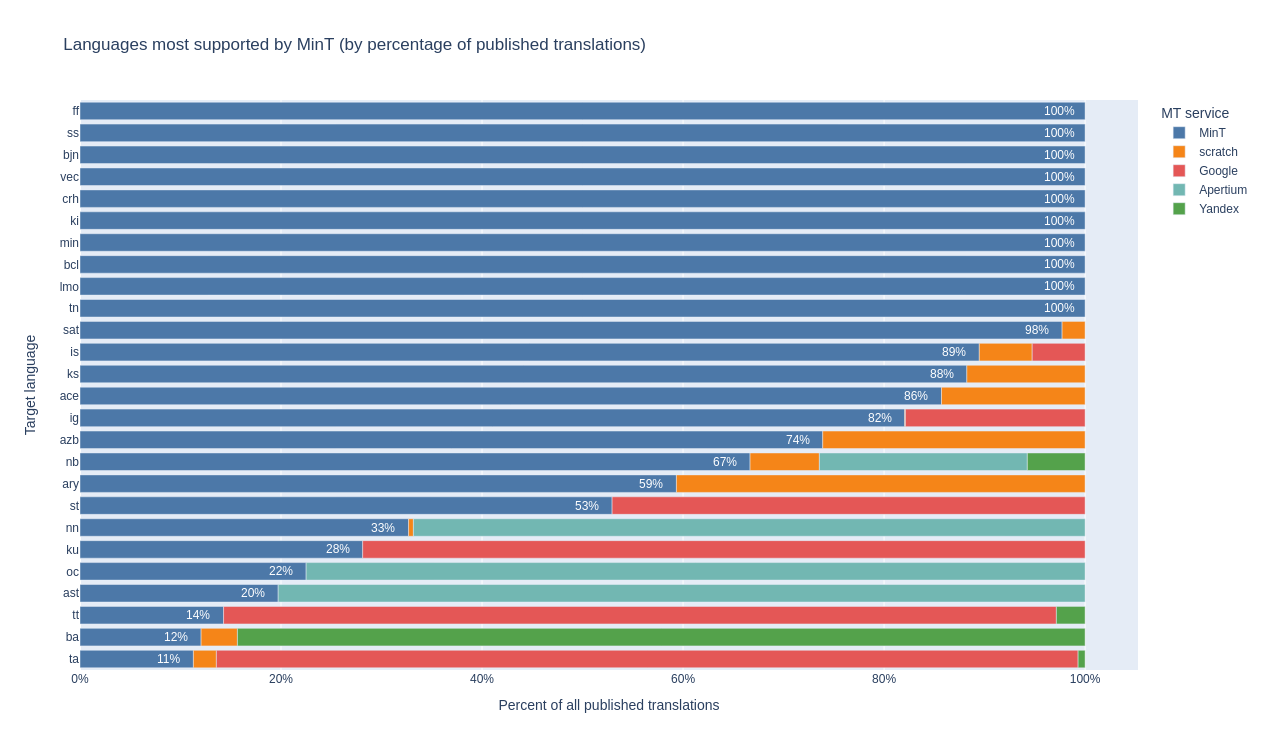

In [63]:
iplot(chart_usage('MinT', chart_height=750, chart_width=iplot_width, return_fig=True, min_translations=5), config=iplot_config)

**Summary**<br>*among languages where there have been at least 5 published translations, and MinT accounted for at least 10% of the translations*
- MinT is currently used to support 100% of published translations at Fulah (ff), Swati (ss), Banjar (bjn), Venetian (vec), Crimean Tatar (crh), Kikuyu (ki), Minangkabau (min), Bikol Central (bcl), Lombard (lmo), and Tswana (tn).
- On Santali (sat), Icelandic (is), Kashmiri (ks), Acehnese (ace), Igbo (ig), South Azerbaijani (azb), Norwegian (nb), Moroccan Arabic (ary), and Sesotho (st), MinT accounts for majority of the translations.

### Google
[Google Translate](https://www.mediawiki.org/w/index.php?title=Content_translation/Machine_Translation/Google_Translate&useskin=vector-2022) is the most frequently used machine translation service (used for 80.28% of all published translations) and supports about 100 languages.

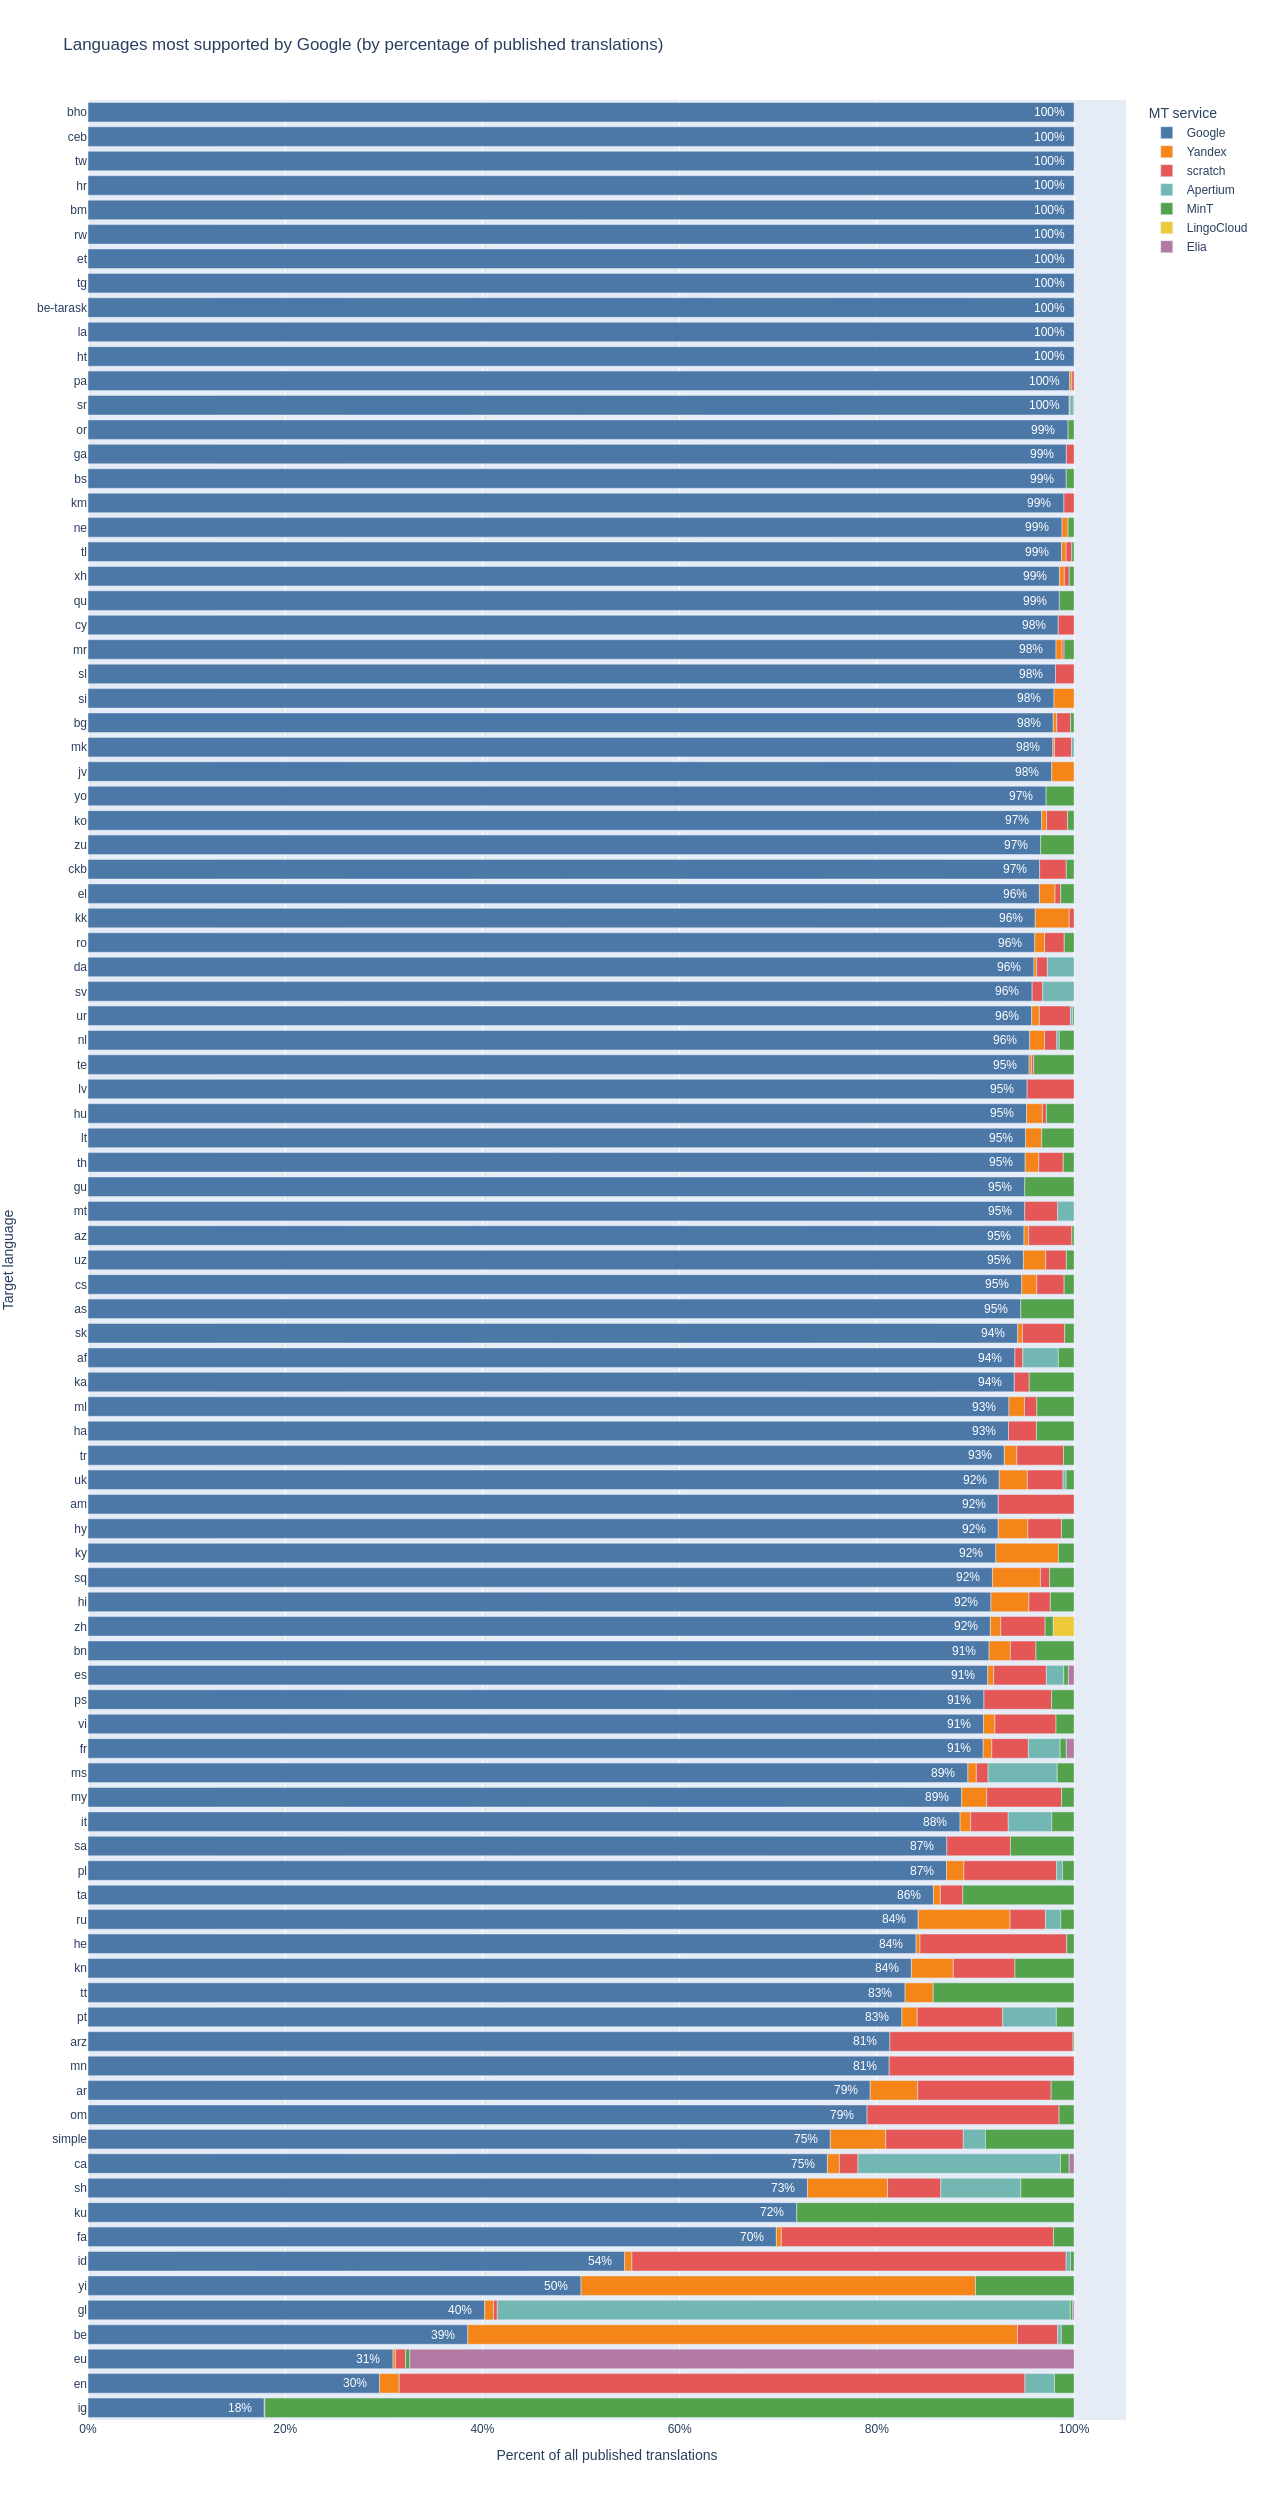

In [26]:
iplot(chart_usage('Google', chart_height=2500, chart_width=iplot_width, return_fig=True), config=iplot_config)

**Summary**<br>*among languages where there have been at least 10 published translations, and Google accounted for at least 10% of the translations*
- Google Translate was used to translate 100% of translations at many target languages including languages where it is the default or only available service. 
- In 83 languages, where Google is used for majority of the published translations.

### Yandex
[Yandex](https://www.mediawiki.org/w/index.php?title=Content_translation/Machine_Translation/Yandex&useskin=vector-2022) has been available for Content Translation tool users since 4 November 2015. During August and October 2023, it accounted for 1.91% of all published translations.

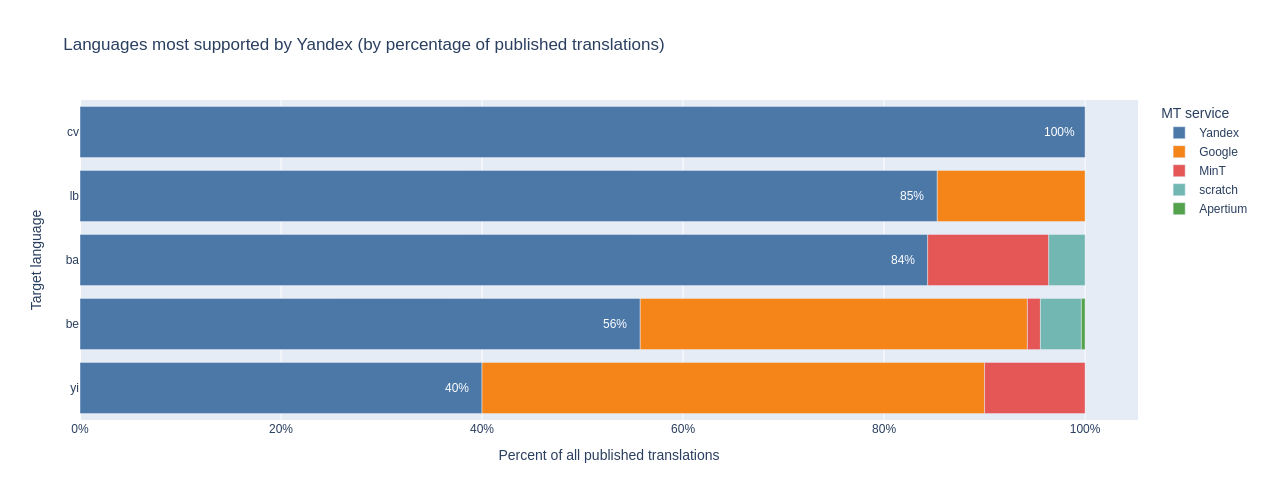

In [27]:
iplot(chart_usage('Yandex', chart_height=500, chart_width=iplot_width, return_fig=True, min_translations=5), config=iplot_config)

**Summary**<br>*among languages where there have been at least 5 published translations, and Yandex accounted for at least 10% of the translations*
* Yandex is used for majority of the translations on Chuvash (cv), Luxembourgish (lb), Bashkir (ba), and Belarusian (be).

### Apertium
From August to October 2023, Apertium accounted for 2.72% of all published translations.

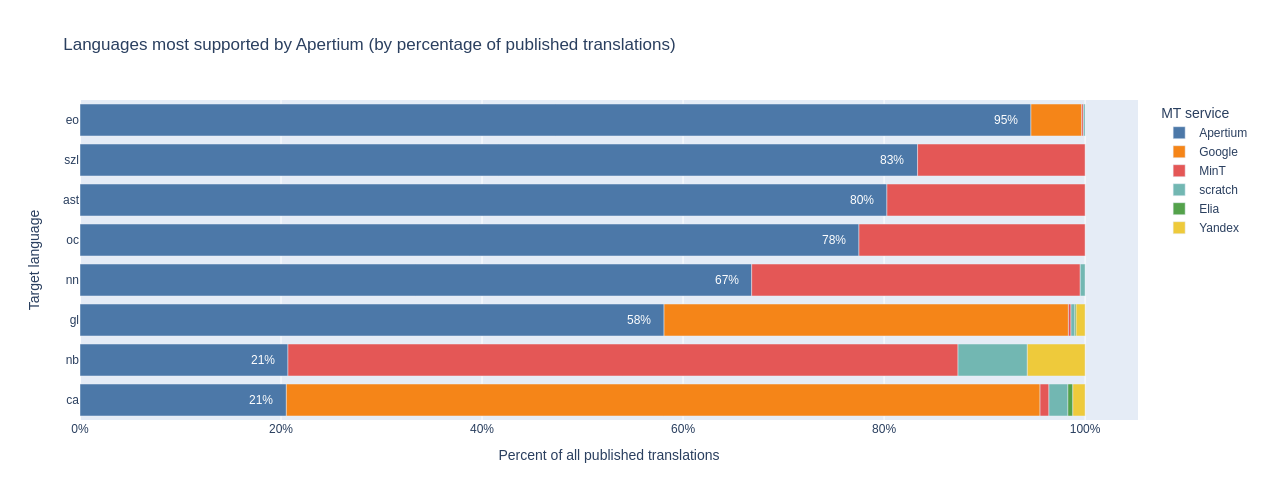

In [28]:
iplot(chart_usage('Apertium', chart_height=500, chart_width=iplot_width, return_fig=True, min_translations=5), config=iplot_config)

**Summary**<br>*among languages where there have been at least 5 published translations, and Apertium accounted for at least 10% of the translations*
* Apertium is used for majority of the translations on Esperanto (eo), Silesian (szl), Asturian (ast), Occitan (oct), Norwegian Nynorsk (nn), and Galician (gl).

### Elia
From August to October 2023, Elia accounted for 1.1% of all published translations.

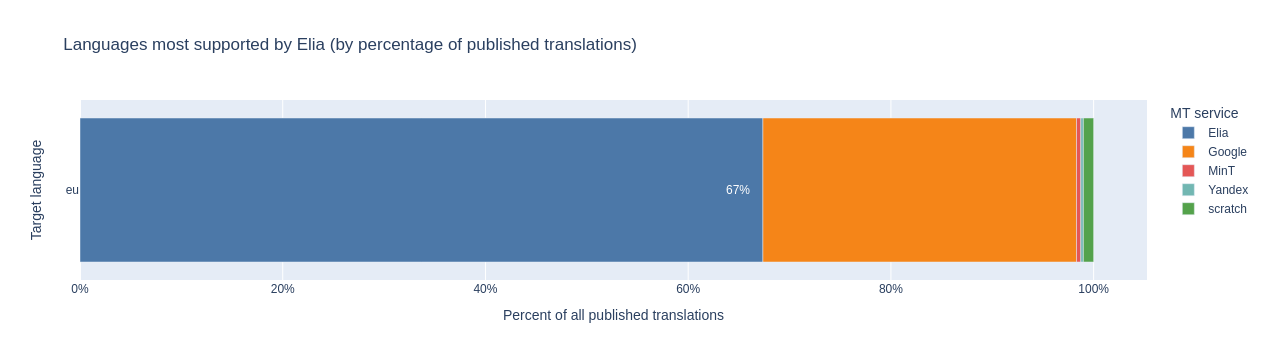

In [29]:
iplot(chart_usage('Elia', min_translations=5, min_percent=0.05, chart_height=300, chart_width=iplot_width, return_fig=True), config=iplot_config)

### LingoCloud
From August to October 2023, LingoCloud accounted for 0.05% of all published translations.

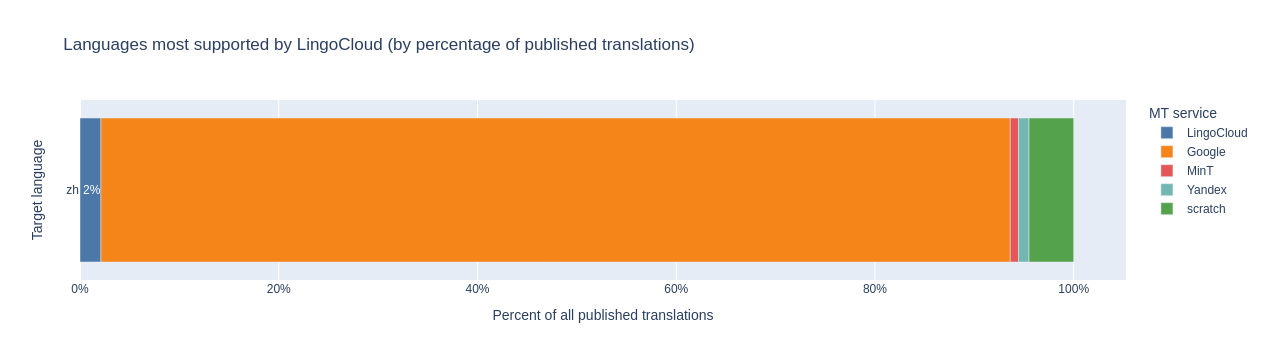

In [30]:
iplot(chart_usage('LingoCloud', min_translations=1, min_percent=0, chart_height=300, xlabel_offset=0.009, chart_width=iplot_width, return_fig=True), config=iplot_config)

### No MT service used

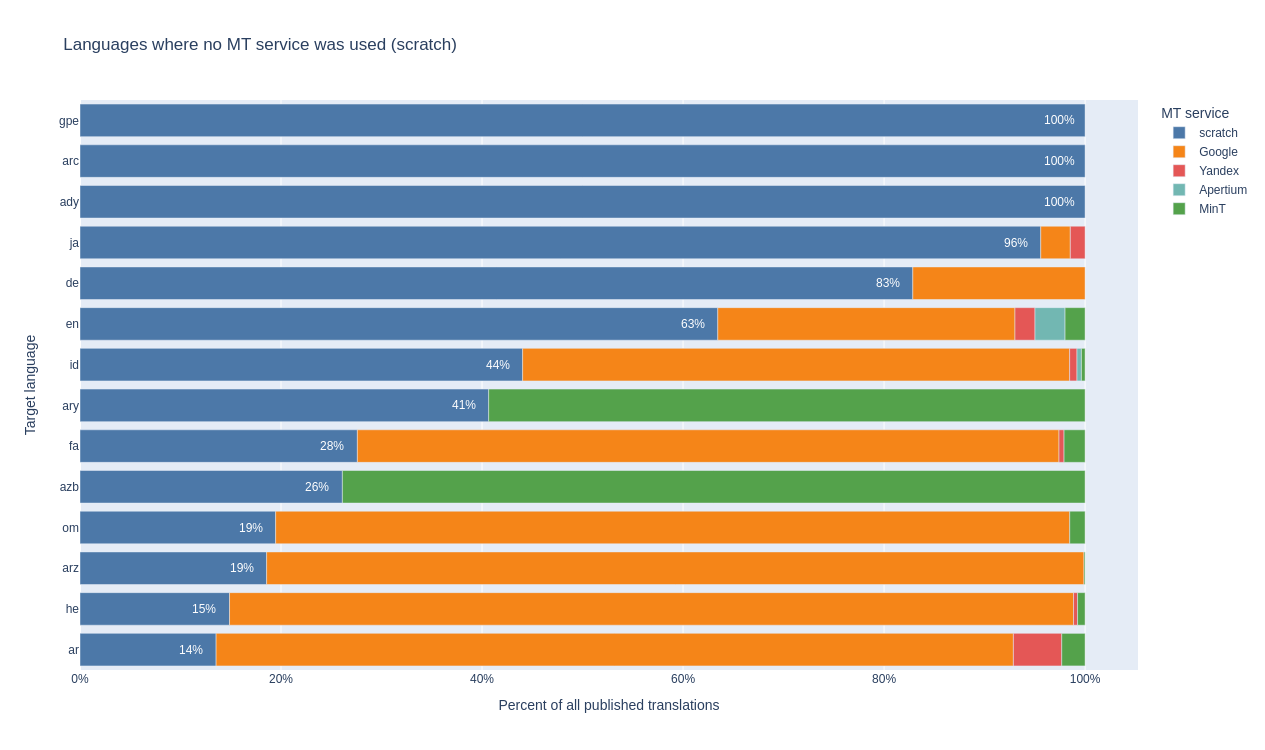

In [31]:
iplot(chart_usage('scratch', chart_height=750, chart_width=iplot_width, return_fig=True), config=iplot_config)

**Summary**<br>*among languages where there have been at least 10 published translations, and no machine translation was used for more 10% of the translations*
* On Ghanaian Pidgin (gpe), Aramaic (arc), and Adyghe (ady), all the translations were made without any machine translation support.
* on Japanese (ja) & German (de), majority of the translations were made  without any machine translation support.
* On Indonesian (id), Moroccan Arabic (ary), Farse (fa), and South Azerbaijani (azb), about 1/3rd of the translations were made  without any machine translation support.

# Percent-machine-translation-content-modified

The content provided by each machine translation service can be modified by the user before publishing. The analysis tracks the percentage each translation is modified by the user before publication. Following the MT abuse calculation documentation, a warning or error is displayed to the user based on the extent of unmodified content. This encourages users to make further edits. Depending on the situation, some users may still be able to publish their translations, but the resulting page may be added to a tracking category for potentially unreviewed translations, subject to community review. In other cases, users may not be allowed to publish.

For the purpose of this analysis, we have focused on published translations and have categorized the extent to which machine translation content was modified by users into three categories: less than 10%, between 10% and 50%, and over 50%. These categories can be adjusted as needed.

**Method:** Data on percent each translation is modified comes from the translations_progress field [^Note] in the cx_translation table (as indicated by the human percentage stat).

[^Note]: The translations_progress data shows the percentage of translation completion. human indicates manual translation percentage. mt indicates machine translation percentage. Any edits to machine translation output are considered as manual edits. The percentages are calculated at section level. any indicates the total translation (any=human+mt). Content Translation does not demand full translation of the source article.

In [32]:
# create an unaggregated temporary view with percent modified column
conn.sql("""
CREATE OR REPLACE VIEW hpct_modified AS
SELECT
    *,
    CASE 
        WHEN human_translated_percent < 0.1 THEN 'less than 10%'
        WHEN human_translated_percent >= 0.1 AND human_translated_percent <= 0.5 THEN 'between 10% and 50%'
        WHEN human_translated_percent >0.5 THEN 'over 50%'
    END AS 'pct_modified'
FROM
    mt_logs
WHERE
    translation_start_time >= '2023-08-01' 
    AND translation_start_time <= '2023-10-31'
    AND mt_service != 'scratch'
""")

In [33]:
# overall percentage modified
pct_modified_overall = query("""
WITH 
    base AS (
        SELECT
            mt_service,
            pct_modified,
            COUNT(DISTINCT translation_id) AS n_translations
        FROM
            hpct_modified
        GROUP BY
            mt_service,
            pct_modified
        )
        
SELECT
    *,
    n_translations / SUM(n_translations) OVER (PARTITION BY mt_service) AS pct_translations
FROM
    base
""", True)

In [34]:
pct_order = ['less than 10%', 'between 10% and 50%', 'over 50%']

# chart function
def chart_pct_modified(df, title, pct_order=pct_order, iplot_width=800):
    
    mt_service_order = (
        df
        .query("""pct_modified == 'less than 10%'""")
        .sort_values('pct_translations', ascending=False)
        .mt_service
        .unique()
        .tolist()
    )

    df['mt_service'] = pd.Categorical(df['mt_service'], categories=mt_service_order, ordered=True)
    df['pct_modified'] = pd.Categorical(df['pct_modified'], categories=pct_order, ordered=True)
    df = df.sort_values(['mt_service', 'pct_modified'], ascending=[True, True])

    fig = go.Figure()

    for pct_mod in pct_order:
        data = df[df['pct_modified'] == pct_mod]
        fig.add_trace(go.Bar(
            x=data['pct_translations'],
            y=data['mt_service'],
            orientation='h',
            name=pct_mod,
            text=[f"{val:.0%}" for val in data['pct_translations']],  # Format text labels as percentages
            textposition='auto',
            textfont_color='white',
            marker_color={pct: px.colors.qualitative.T10[i] for i, pct in enumerate(pct_order)}[pct_mod] 
        ))

    fig.update_layout(
        barmode='stack',
        height=600,
        width=iplot_width,
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1
        ),
        xaxis_tickformat=".0%",
        title=title
    )

    return fig

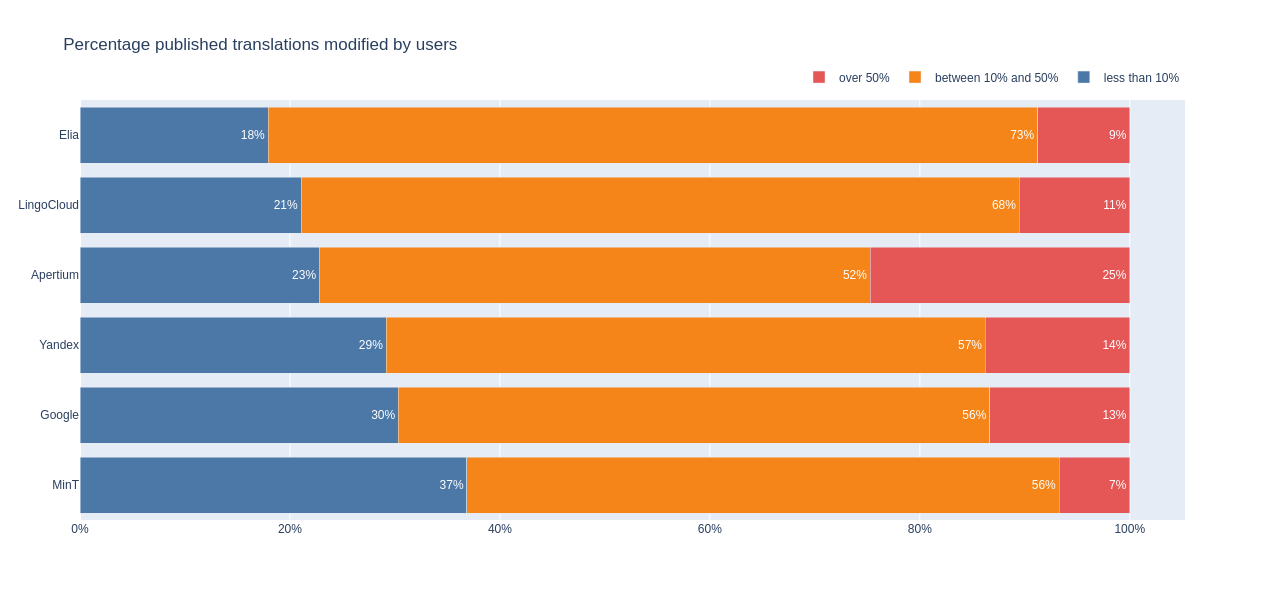

In [35]:
iplot(chart_pct_modified(pct_modified_overall, 'Percentage published translations modified by users'), config=iplot_config)

**Summary**
* Majority of the translations across all MT services were modified at least 10% during publication.
* MinT has higher percentage slightly modified content compared to other services: 37% of the translations were modified less than 10%, and 93% of the all translations were modified less than 50% by users.
* 25% of the translations published using Apertium, more than 50% of the content was modified, which is highest among all services.

### at MinT supported languages

In [36]:
pct_modified_mint_langs = query("""
WITH
    mint_langs AS (
        SELECT
            target_language,
            COUNT(DISTINCT translation_id) AS n_translations
        FROM
            hpct_modified
        WHERE
            mt_service = 'MinT'
        GROUP BY
            target_language
    ),
    
    base AS (
        SELECT
            mt_service,
            pct_modified,
            COUNT(DISTINCT translation_id) AS n_translations
        FROM
            hpct_modified
        WHERE
            target_language IN (SELECT DISTINCT target_language FROM mint_langs WHERE n_translations >= 10)
        GROUP BY
            mt_service,
            pct_modified
        )
    
SELECT
    *,
    n_translations / SUM(n_translations) OVER (PARTITION BY mt_service) AS pct_translations
FROM
    base
""", True)

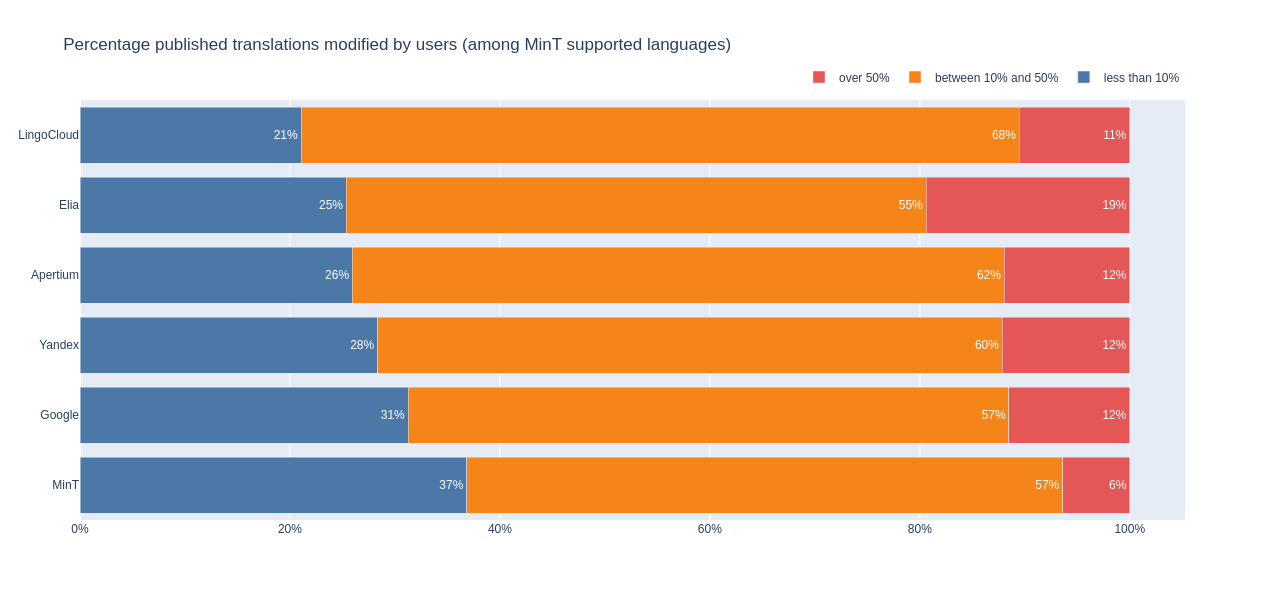

In [37]:
iplot(chart_pct_modified(pct_modified_mint_langs, 'Percentage published translations modified by users (among MinT supported languages)'), config=iplot_config)

### Percent of MT modified content by language (at MinT supported language)

In [38]:
pct_modified_mint_by_lang = query("""
WITH
    mint_langs AS (
        SELECT
            target_language,
            COUNT(DISTINCT translation_id) AS n_translations
        FROM
            hpct_modified
        WHERE
            mt_service = 'MinT'
        GROUP BY
            target_language
    ),
    
    base AS (
        SELECT
            mt_service,
            pct_modified,
            target_language,
            COUNT(DISTINCT translation_id) AS n_translations
        FROM
            hpct_modified
        WHERE
            target_language IN (SELECT DISTINCT target_language FROM mint_langs WHERE n_translations >= 10)
        GROUP BY
            mt_service,
            pct_modified,
            target_language
        )
    
SELECT
    *,
    n_translations / SUM(n_translations) OVER (PARTITION BY target_language, mt_service) AS pct_translations
FROM
    base
""", True)

In [39]:
pct_modified_mint_by_lang['pct_modified'] = pd.Categorical(pct_modified_mint_by_lang['pct_modified'], categories=pct_order, ordered=True)
pct_modified_mint_by_lang = pct_modified_mint_by_lang.sort_values(['pct_modified'], ascending=[True])

In [40]:
color_mapping = {
    'less than 10%': px.colors.qualitative.T10[0],
    'between 10% and 50%': px.colors.qualitative.T10[1],
    'over 50%': px.colors.qualitative.T10[2]
}

unique_target_languages = pct_modified_mint_by_lang['target_language'].unique()
num_rows = (len(unique_target_languages) + 2) // 3

fig = sp.make_subplots(rows=num_rows, cols=3, subplot_titles=unique_target_languages, horizontal_spacing=0.1, vertical_spacing=0.025, shared_xaxes=True, specs=[[{}, {}, {}]]*num_rows)

all_traces = []

for i, target_language in enumerate(unique_target_languages):
    row_num = i // 3 + 1
    col_num = i % 3 + 1
    
    filtered_data = pct_modified_mint_by_lang.query(f"target_language == '{target_language}'")
    
    traces = []
    categories = filtered_data['pct_modified'].unique()

    for category in categories:
        category_data = filtered_data[filtered_data['pct_modified'] == category]
        
        trace = go.Bar(
            x=category_data['pct_translations'],
            y=category_data['mt_service'],
            orientation='h',
            name=category,
            marker=dict(color=color_mapping[category]),
            text=[f"{val:.0%}" if val > 0.2 else '' for val in category_data['pct_translations']],  # Format text labels as percentages,
            textposition='auto',
            textfont=dict(size=10)
        )
        
        traces.append(trace)
        
        
    for trace in traces:
        fig.add_trace(trace, row=row_num, col=col_num)

    
fig.update_layout(
    title="Percentage published translations modified by users at MinT supported languages",
    height=200 * num_rows,
    width=950,
    barmode='stack',
    showlegend=False
)

for row_num in range(1, num_rows + 1):
    for col_num in range(1, 4):  # Assuming 3 columns
        fig.update_xaxes(tickformat=".0%", row=row_num, col=col_num)

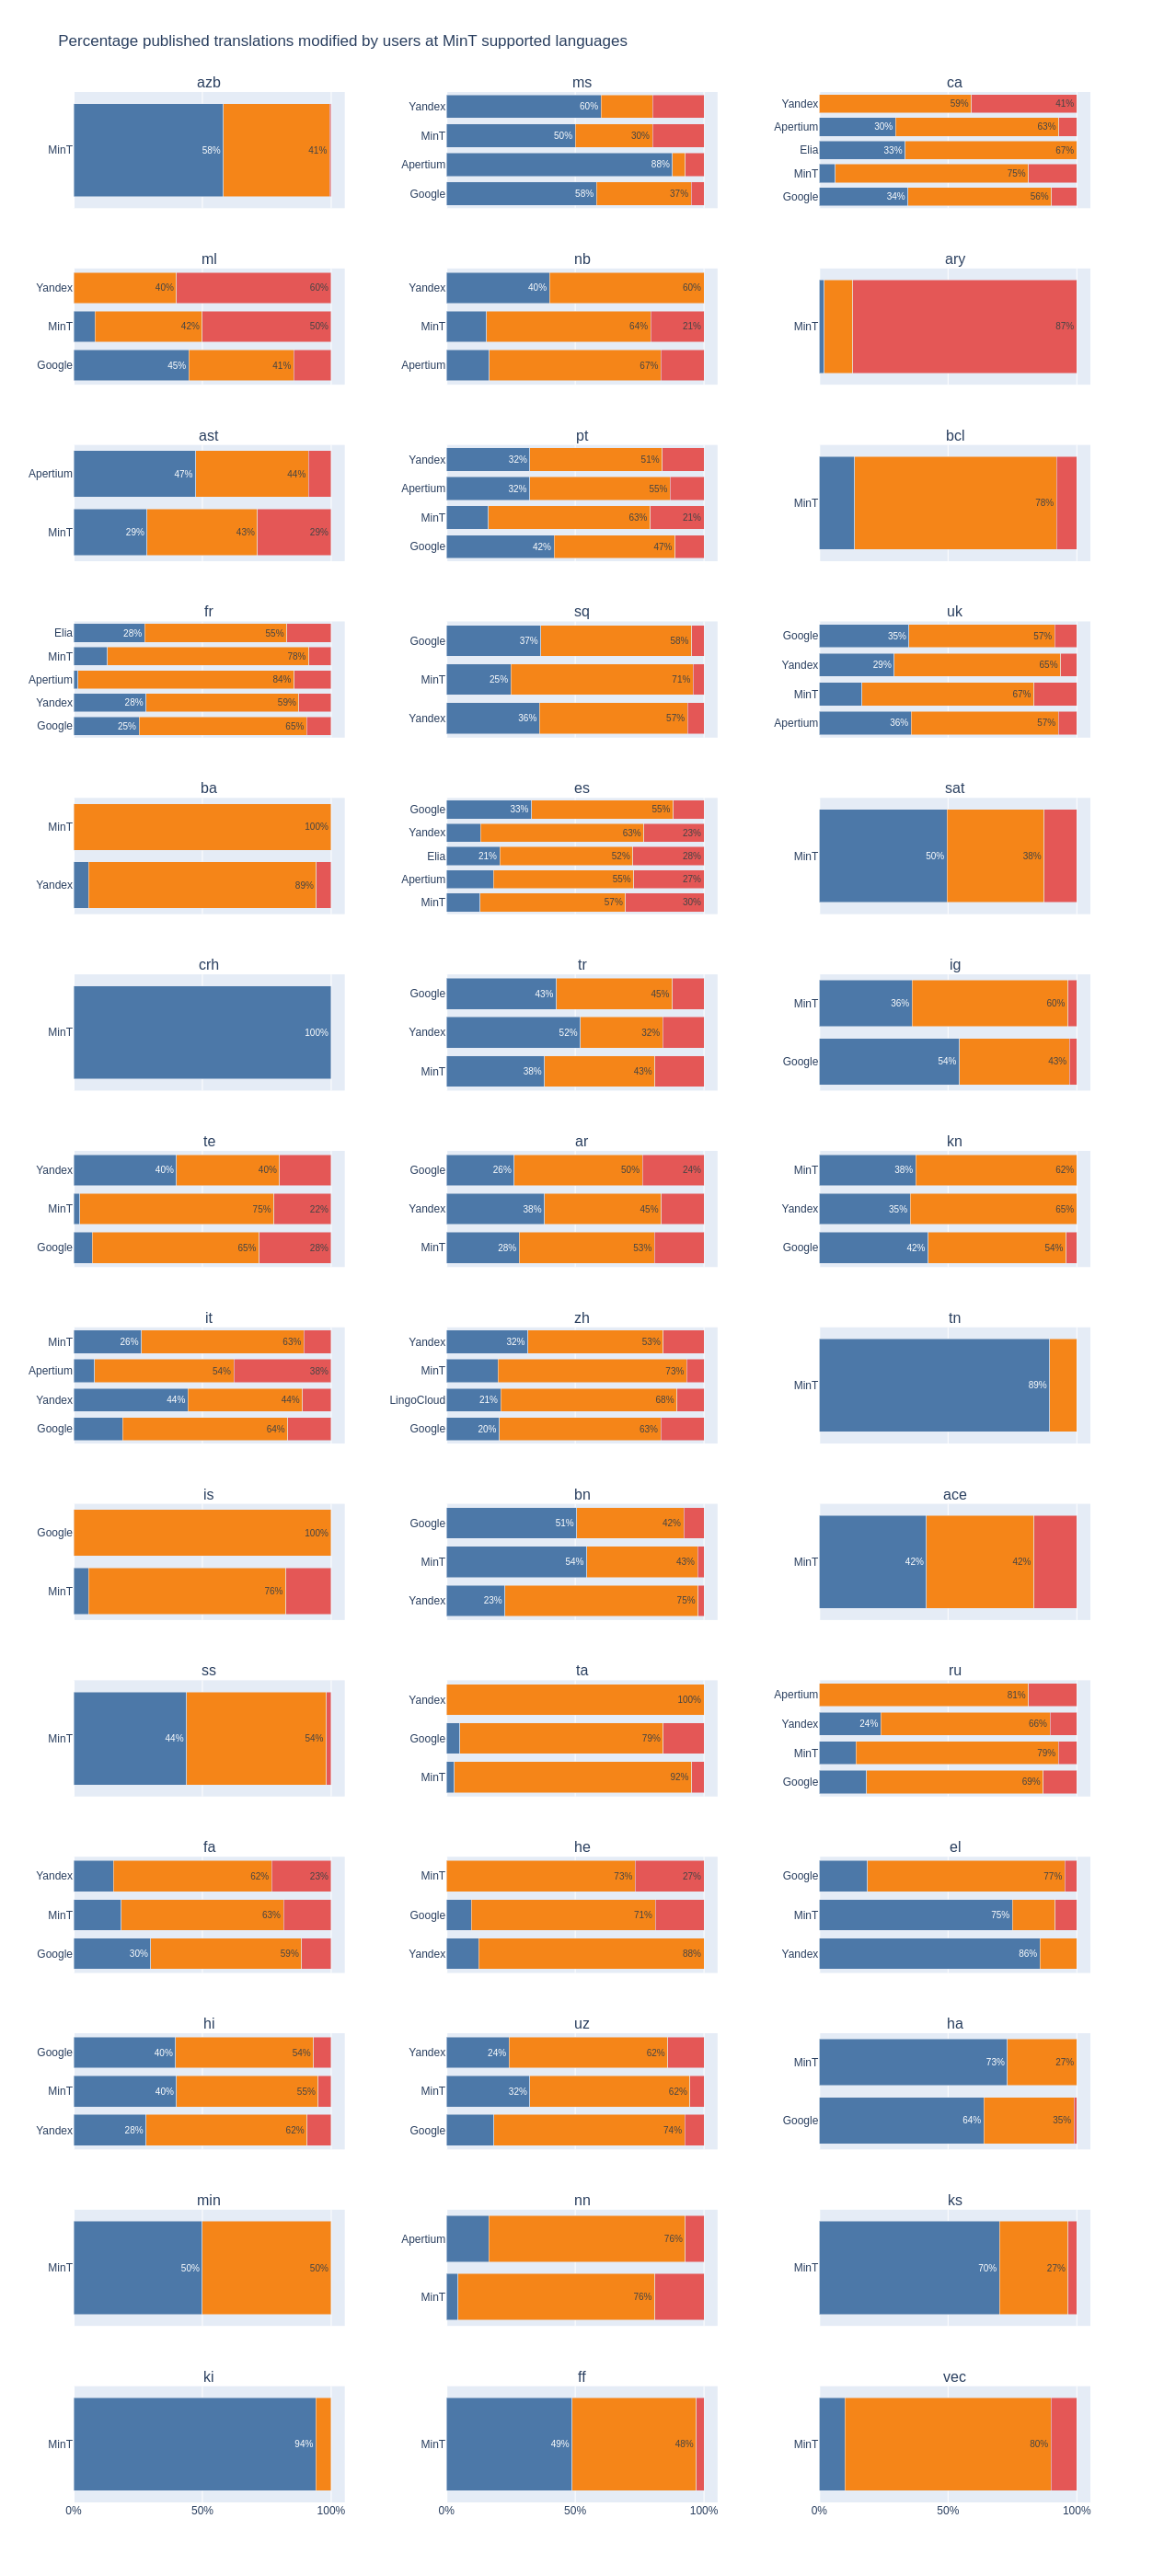

In [120]:
iplot(fig, config=iplot_config)

## Percent of articles that are created with each MT service and deleted

In [57]:
# deletion rates overall
mt_deletion_overall = query("""
SELECT
    mtd.mt_service AS 'Machine Translation Service',
    SUM(deleted_cx_total)::INT AS 'Number of Articles Deleted',
    SUM(created_cx_total)::INT AS 'Number of Articles Created',
    SUM(deleted_cx_total) / SUM(created_cx_total)  AS 'Percentage of deleted articles',
    pct_translations AS 'Percent of translations modified under 10%'
FROM
    mt_deletion_ratios mtd
LEFT JOIN (
    SELECT
        mt_service,
        pct_translations
    FROM
        pct_modified_overall
    WHERE
        pct_modified = 'less than 10%'
    ) pct_modf
    ON mtd.mt_service = pct_modf.mt_service
GROUP BY
    mtd.mt_service,
    pct_translations
""", True).sort_values('Number of Articles Created', ascending=False)

In [58]:
mt_deletion_overall['Percentage of deleted articles'] = format_percent('Percentage of deleted articles', mt_deletion_overall)
mt_deletion_overall['Percent of translations modified under 10%'] = format_percent('Percent of translations modified under 10%', mt_deletion_overall)

mt_deletion_overall.set_index('Machine Translation Service', inplace=True)
mt_deletion_overall.loc['scratch', 'Percent of translations modified under 10%'] = 'n/a'

In [59]:
pr_centered('Percentage of articles deleted, by Machine Translation Service', True)
pr_centered('August to October 2023')
display_h({
    '': mt_deletion_overall
})

,Number of Articles Deleted,Number of Articles Created,Percentage of deleted articles,Percent of translations modified under 10%
Machine Translation Service,,,,
Google,2926,56201,5.21%,30.34%
MinT,97,5655,1.72%,36.86%
scratch,166,4185,3.97%,n/a
Apertium,56,1994,2.81%,22.81%
Yandex,81,1299,6.24%,29.17%
Elia,15,811,1.85%,17.92%
LingoCloud,0,35,0.00%,21.05%


**Summary**
* Across all languages, MinT has lowest percentage of articles that were deleted (1.72%), and compared to all other services, it has the highest percent of translations modified under 10%, indicating that the modifications rates for this machine translations service are a signal of good machine translation quality.
* Yandex and Google are the top services with higher deletion rates than the rest, 6.24% and 5.21% respectively.
* About 4% of the articles translated without support of any MT service, were deleted.

### Deletion rates at MinT supported languages, by wiki

In [61]:
# get deletion rates by wiki
mt_deletion_mint_langs = query("""
WITH
    mint_langs AS (
        SELECT
            COUNT(DISTINCT translation_id) AS n_translations,
            target_language||'wiki' AS wiki
        FROM 
            mt_logs
        WHERE 
            mt_service = 'MinT' 
        GROUP BY
            target_language),
    
    deletion_ratios AS (
        SELECT
            *
        FROM 
            mt_deletion_ratios
        WHERE
            wiki IN (SELECT DISTINCT wiki FROM mint_langs WHERE n_translations > 15)
        )
            
SELECT * FROM deletion_ratios
""", True)

In [121]:
mt_deletion_mint_langs_min1 = mt_deletion_mint_langs.query("""deletion_ratio > 0.01""")
unique_wikis = mt_deletion_mint_langs_min1['wiki'].unique()

num_wikis = len(unique_wikis)
num_rows = (num_wikis + 2) // 3

fig = sp.make_subplots(rows=num_rows, cols=3, subplot_titles=unique_wikis, horizontal_spacing=0.1, vertical_spacing=0.035, shared_yaxes=True)

traces = []

for i, wiki in enumerate(unique_wikis):
    row_num = i // 3 + 1
    col_num = i % 3 + 1
    
    wiki_data = mt_deletion_mint_langs_min1[mt_deletion_mint_langs_min1['wiki'] == wiki].sort_values('deletion_ratio')
        
    trace = go.Bar(
        x=wiki_data['mt_service'],
        y=wiki_data['deletion_ratio'],
        name=wiki,
        text=[f"{val:.0%}" for val in wiki_data['deletion_ratio']],
        textposition='auto',
        textfont=dict(size=10),
        marker=dict(color='RoyalBlue')
    )
    
    traces.append(trace)
    
    fig.add_trace(trace, row=row_num, col=col_num)

fig.update_layout(
    title="Deletion Ratio by MT Service at MinT supported languages",
    height=200 * num_rows,
    width=950,
    showlegend=False
)

for row_num in range(1, num_rows + 1):
    for col_num in range(1, 4):
        fig.update_xaxes(row=row_num, col=col_num)
        fig.update_yaxes(tickformat=".0%", row=row_num, col=col_num, title_text='', range=[0, 0.5])

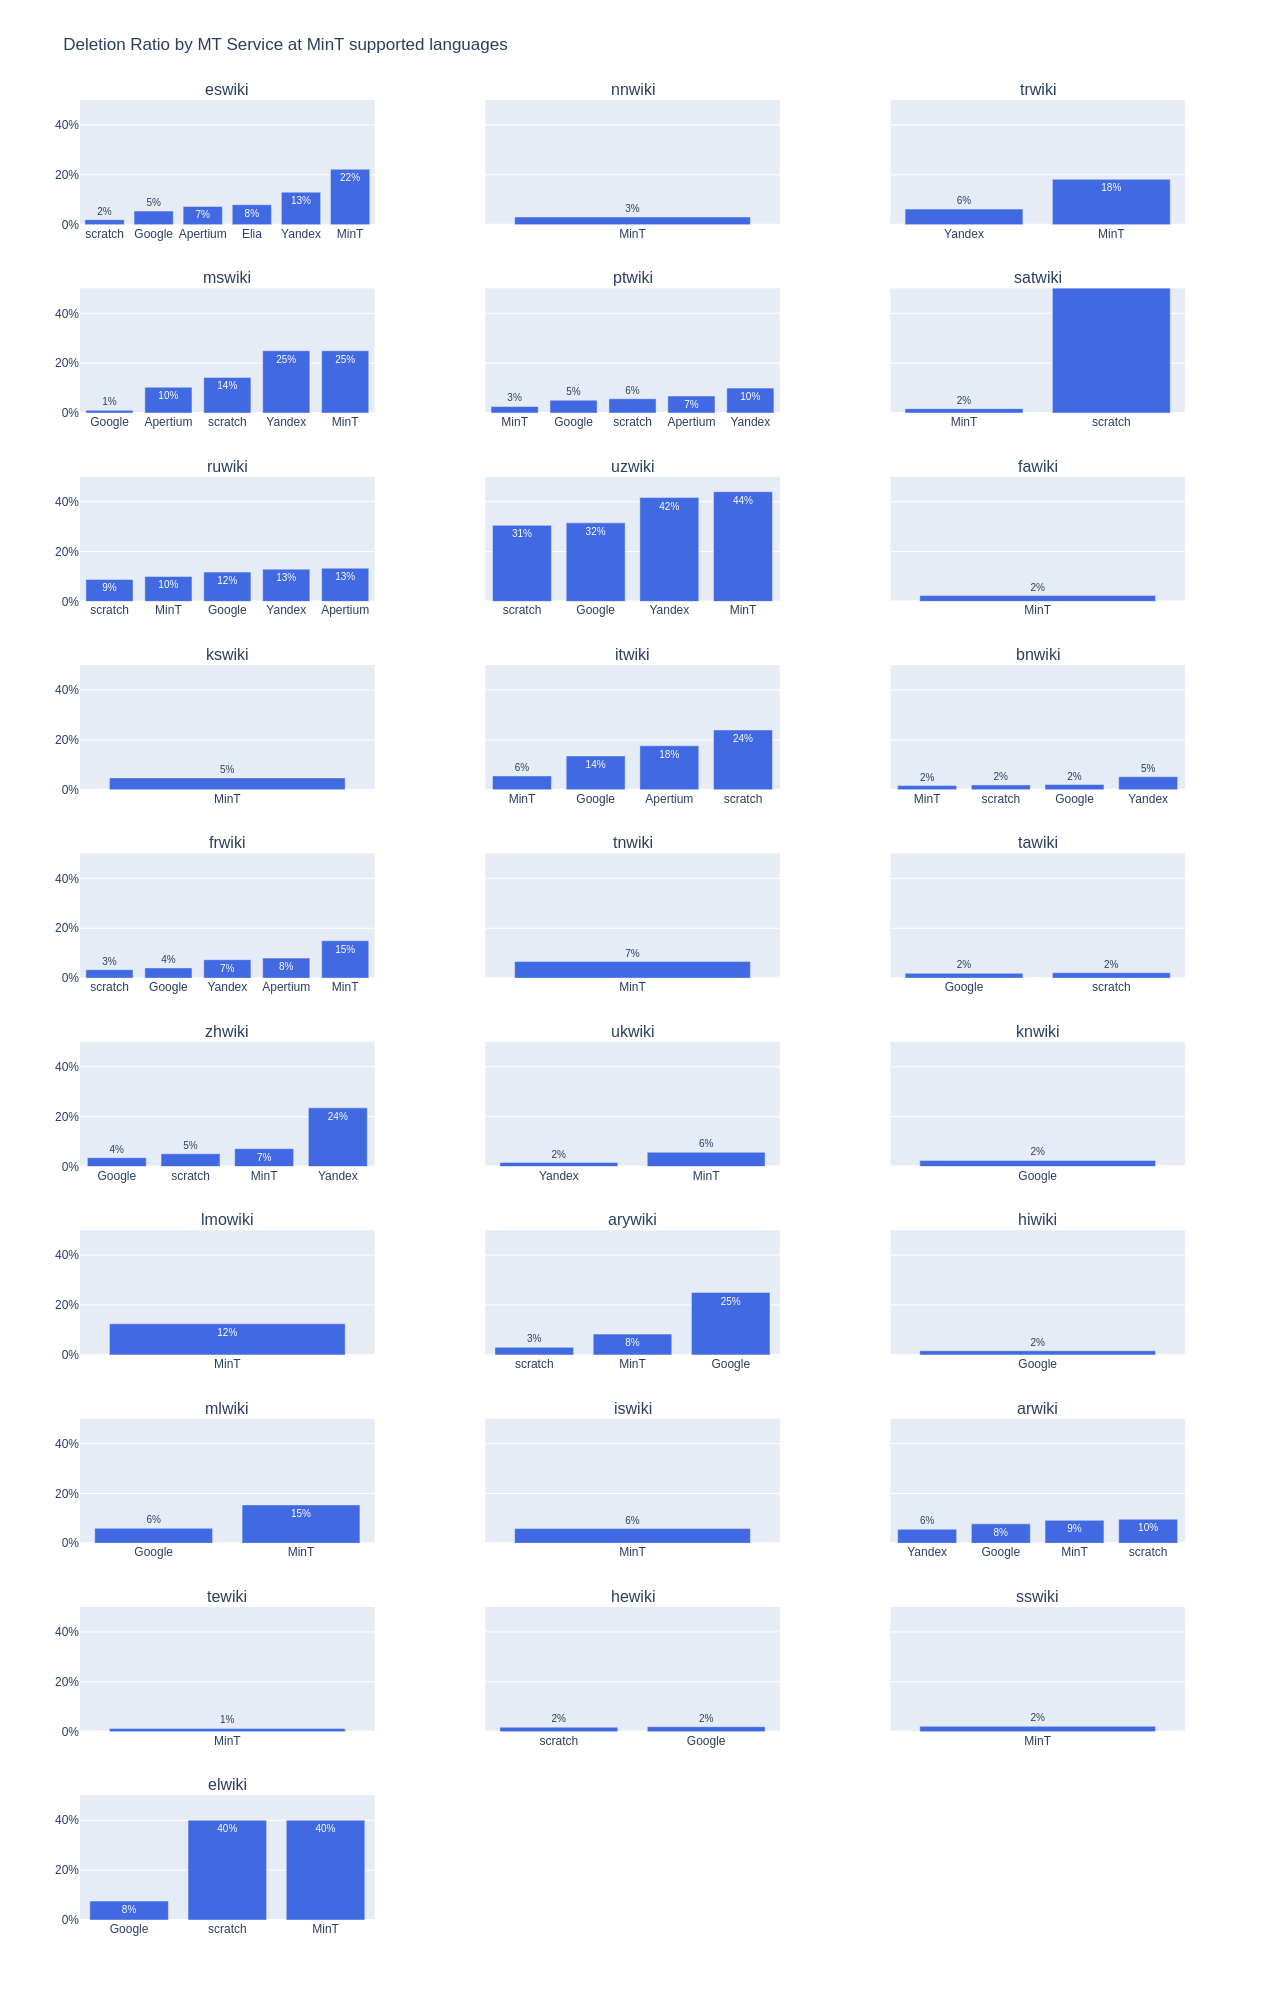

In [122]:
iplot(fig, config=iplot_config)

**Summary**
* Wikipedias where articles created with MinT were deleted at a higher rate compared to the rest of the services: Spanish (es), Malay (ms), Turkish (tr), French (fr), Uzbek (uz), Greek (el), and Malayalam (ml).
* Wikipedias where articles created with MinT were deleted at a lower rate compared to the rest of the services: Portugese (pt), Russian (ru), Bengali (bn), and Italian (it).
* On Santali (sat), all articles translated without any MT support were deleted, where only 2% of the articles translated using MinT were deleted.

# YoY-service-usage-comparision
Identify languag pairs where there has been a significant change in the service used compared to 2022.

In [64]:
# get yoy comparision
yoy_comparision_service_comparision = query(f"""
WITH
    base AS (
        SELECT
            source_language,
            target_language,
            mt_service,
            COUNT(DISTINCT translation_id) AS n_translations,
            EXTRACT(YEAR FROM translation_start_time) AS translation_year
        FROM 
            mt_logs
        WHERE
            (translation_start_time >= '2023-08-01' AND translation_start_time <= '2023-10-31')
            OR
            (translation_start_time >= '2022-08-01' AND translation_start_time <= '2022-10-31')
        GROUP BY
            source_language,
            target_language,
            mt_service,
            translation_year
    )
SELECT
    source_language,
    target_language,
    mt_service,
    SUM(CASE WHEN translation_year = 2022 THEN n_translations ELSE 0 END) AS n_translations_2022,
    SUM(CASE WHEN translation_year = 2023 THEN n_translations ELSE 0 END) AS n_translations_2023,
    CASE 
        WHEN SUM(CASE WHEN translation_year = 2022 THEN n_translations ELSE 0 END) > 0
        THEN SUM(CASE WHEN translation_year = 2022 THEN n_translations ELSE 0 END) / 
             SUM(CASE WHEN translation_year = 2022 THEN n_translations ELSE 0 END +
                 CASE WHEN translation_year = 2023 THEN n_translations ELSE 0 END)
        ELSE NULL
    END AS pct_translations_2022,
    CASE 
        WHEN SUM(CASE WHEN translation_year = 2023 THEN n_translations ELSE 0 END) > 0
        THEN SUM(CASE WHEN translation_year = 2023 THEN n_translations ELSE 0 END) / 
             SUM(CASE WHEN translation_year = 2022 THEN n_translations ELSE 0 END +
                 CASE WHEN translation_year = 2023 THEN n_translations ELSE 0 END)
        ELSE NULL
    END AS pct_translations_2023
FROM
    base
GROUP BY
    source_language,
    target_language,
    mt_service
ORDER BY
    source_language,
    target_language,
    mt_service
    """, True)

In [65]:
def calculate_yoy_differences(service, df=yoy_comparision_service_comparision, min_diff=0.40, min_translations=25):
    filtered_df = df[(df['mt_service'] == service) & (df['n_translations_2022'] > min_translations)]
    
    filtered_df['pct_diff'] = filtered_df['pct_translations_2023'] - filtered_df['pct_translations_2022']
    
    filtered_df = filtered_df[abs(filtered_df['pct_diff']) >= min_diff]
    
    formatted_df = filtered_df.copy()
    percentage_columns = ['pct_translations_2022', 'pct_translations_2023', 'pct_diff']
    for col in percentage_columns:
        formatted_df[col] = formatted_df[col].apply(lambda x: f"{x:.2%}")
    
    filtered_df = filtered_df.astype({'n_translations_2022': int, 'n_translations_2023': int})
    
    column_mapping = {
        'source_language': 'Source',
        'target_language': 'Target',
        'n_translations_2022': '# Translations 2022',
        'n_translations_2023': '# Translations 2023',
        'pct_translations_2022': '% of Translations 2022',
        'pct_translations_2023': '% of Translations 2023',
        'pct_diff': '% Difference of all Translations',
    }
    formatted_df.rename(columns=column_mapping, inplace=True)
    
    formatted_df.set_index(['Source', 'Target'], inplace=True)
    
    return formatted_df

## Google

In [66]:
pr_centered('Languages pairs where has been a major change in percentage of translations made using Google', True)
pr_centered('with minimum 25 published translations and the difference is more than 40%')
display_h({
    '': calculate_yoy_differences('Google')
})

mt_service 
 # Translations 2022 
 # Translations 2023 
 % of Translations 2022 
 % of Translations 2023 
 % Difference of all Translations 
 
 
 Source 
 Target 
 
 
 
 
 
 
 
 
 
 
 ar 
 ckb 
 Google 
 41.0 
 237.0 
 14.75% 
 85.25% 
 70.50% 
 
 
 az 
 ka 
 Google 
 46.0 
 4.0 
 92.00% 
 8.00% 
 -84.00% 
 
 
 be 
 ru 
 Google 
 321.0 
 10.0 
 96.98% 
 3.02% 
 -93.96% 
 
 
 bs 
 sr 
 Google 
 83.0 
 739.0 
 10.10% 
 89.90% 
 79.81% 
 
 
 ceb 
 es 
 Google 
 73.0 
 19.0 
 79.35% 
 20.65% 
 -58.70% 
 
 
 de 
 fa 
 Google 
 49.0 
 1.0 
 98.00% 
 2.00% 
 -96.00% 
 
 
 hr 
 Google 
 34.0 
 2.0 
 94.44% 
 5.56% 
 -88.89% 
 
 
 it 
 Google 
 77.0 
 32.0 
 70.64% 
 29.36% 
 -41.28% 
 
 
 ku 
 Google 
 36.0 
 1.0 
 97.30% 
 2.70% 
 -94.59% 
 
 
 nl 
 Google 
 59.0 
 17.0 
 77.63% 
 22.37% 
 -55.26% 
 
 
 ru 
 Google 
 44.0 
 14.0 
 75.86% 
 24.14% 
 -51.72% 
 
 
 tr 
 Google 
 42.0 
 14.0 
 75.00% 
 25.00% 
 -50.00% 
 
 
 en 
 af 
 Google 
 79.0 
 222.0 
 26.25% 
 73.75% 
 47.51% 
 
 
 be 
 Google 
 27.0 
 146.0 
 15.61% 
 84.39% 
 68.79% 
 
 
 da 
 Google 
 119.0 
 337.0 
 26.10% 
 73.90% 
 47.81% 
 
 
 fi 
 Google 
 48.0 
 8.0 
 85.71% 
 14.29% 
 -71.43% 
 
 
 ha 
 Google 
 1230.0 
 3528.0 
 25.85% 
 74.15% 
 48.30% 
 
 
 id 
 Google 
 156.0 
 725.0 
 17.71% 
 82.29% 
 64.59% 
 
 
 ig 
 Google 
 28.0 
 743.0 
 3.63% 
 96.37% 
 92.74% 
 
 
 ku 
 Google 
 148.0 
 15.0 
 90.80% 
 9.20% 
 -81.60% 
 
 
 sk 
 Google 
 30.0 
 103.0 
 22.56% 
 77.44% 
 54.89% 
 
 
 sq 
 Google 
 200.0 
 727.0 
 21.57% 
 78.43% 
 56.85% 
 
 
 sw 
 Google 
 34.0 
 4.0 
 89.47% 
 10.53% 
 -78.95% 
 
 
 te 
 Google 
 316.0 
 1867.0 
 14.48% 
 85.52% 
 71.05% 
 
 
 tg 
 Google 
 31.0 
 1.0 
 96.88% 
 3.12% 
 -93.75% 
 
 
 th 
 Google 
 26.0 
 230.0 
 10.16% 
 89.84% 
 79.69% 
 
 
 uz 
 Google 
 13108.0 
 3132.0 
 80.71% 
 19.29% 
 -61.43% 
 
 
 es 
 ar 
 Google 
 36.0 
 14.0 
 72.00% 
 28.00% 
 -44.00% 
 
 
 bn 
 Google 
 108.0 
 6.0 
 94.74% 
 5.26% 
 -89.47% 
 
 
 fa 
 Google 
 59.0 
 1.0 
 98.33% 
 1.67% 
 -96.67% 
 
 
 fr 
 ar 
 Google 
 63.0 
 346.0 
 15.40% 
 84.60% 
 69.19% 
 
 
 cs 
 Google 
 62.0 
 8.0 
 88.57% 
 11.43% 
 -77.14% 
 
 
 gl 
 es 
 Google 
 106.0 
 30.0 
 77.94% 
 22.06% 
 -55.88% 
 
 
 he 
 eo 
 Google 
 67.0 
 2.0 
 97.10% 
 2.90% 
 -94.20% 
 
 
 hu 
 he 
 Google 
 61.0 
 209.0 
 22.59% 
 77.41% 
 54.81% 
 
 
 it 
 fr 
 Google 
 204.0 
 35.0 
 85.36% 
 14.64% 
 -70.71% 
 
 
 ja 
 zh 
 Google 
 84.0 
 228.0 
 26.92% 
 73.08% 
 46.15% 
 
 
 kk 
 uz 
 Google 
 241.0 
 4.0 
 98.37% 
 1.63% 
 -96.73% 
 
 
 pl 
 uk 
 Google 
 51.0 
 239.0 
 17.59% 
 82.41% 
 64.83% 
 
 
 ru 
 el 
 Google 
 31.0 
 1.0 
 96.88% 
 3.12% 
 -93.75% 
 
 
 fr 
 Google 
 27.0 
 73.0 
 27.00% 
 73.00% 
 46.00% 
 
 
 ka 
 Google 
 28.0 
 7.0 
 80.00% 
 20.00% 
 -60.00% 
 
 
 sr 
 Google 
 30.0 
 3.0 
 90.91% 
 9.09% 
 -81.82% 
 
 
 tg 
 Google 
 69.0 
 18.0 
 79.31% 
 20.69% 
 -58.62% 
 
 
 uz 
 Google 
 4074.0 
 1211.0 
 77.09% 
 22.91% 
 -54.17% 
 
 
 simple 
 uz 
 Google 
 33.0 
 4.0 
 89.19% 
 10.81% 
 -78.38% 
 
 
 tr 
 az 
 Google 
 44.0 
 184.0 
 19.30% 
 80.70% 
 61.40% 
 
 
 uz 
 Google 
 242.0 
 69.0 
 77.81% 
 22.19% 
 -55.63% 
 
 
 uk 
 be 
 Google 
 31.0 
 12.0 
 72.09% 
 27.91% 
 -44.19% 
 
 
 ru 
 Google 
 170.0 
 64.0 
 72.65% 
 27.35% 
 -45.30% 
 
 
 ur 
 ps 
 Google 
 263.0 
 31.0 
 89.46% 
 10.54% 
 -78.91% 
 
 
 zh 
 es 
 Google 
 27.0 
 3.0 
 90.00% 
 10.00% 
 -80.00%

## Yandex

In [67]:
pr_centered('Languages pairs where has been a major change in percentage of translations made using Yandex', True)
pr_centered('with minimum 25 published translations and the difference is more than 25%')
display_h({
    '': calculate_yoy_differences('Yandex', min_diff=0.25).drop('mt_service', axis=1)
})

# Translations 2022 
 # Translations 2023 
 % of Translations 2022 
 % of Translations 2023 
 % Difference of all Translations 
 
 
 Source 
 Target 
 
 
 
 
 
 
 
 
 
 en 
 ar 
 39.0 
 195.0 
 16.67% 
 83.33% 
 66.67% 
 
 
 bn 
 107.0 
 43.0 
 71.33% 
 28.67% 
 -42.67% 
 
 
 fa 
 51.0 
 13.0 
 79.69% 
 20.31% 
 -59.38% 
 
 
 he 
 50.0 
 7.0 
 87.72% 
 12.28% 
 -75.44% 
 
 
 nb 
 182.0 
 2.0 
 98.91% 
 1.09% 
 -97.83% 
 
 
 pa 
 28.0 
 1.0 
 96.55% 
 3.45% 
 -93.10% 
 
 
 tr 
 42.0 
 21.0 
 66.67% 
 33.33% 
 -33.33% 
 
 
 uz 
 740.0 
 73.0 
 91.02% 
 8.98% 
 -82.04% 
 
 
 ru 
 ba 
 277.0 
 69.0 
 80.06% 
 19.94% 
 -60.12% 
 
 
 be 
 130.0 
 229.0 
 36.21% 
 63.79% 
 27.58% 
 
 
 uz 
 152.0 
 33.0 
 82.16% 
 17.84% 
 -64.32% 
 
 
 uk 
 be 
 521.0 
 52.0 
 90.92% 
 9.08% 
 -81.85%

## Elia

In [68]:
pr_centered('Languages pairs where has been a major change in percentage of translations made using Elia', True)
pr_centered('with minimum 25 published translations and the difference is more than 25%')
display_h({
    '': calculate_yoy_differences('Elia', min_diff=0.25).drop('mt_service', axis=1)
})

,,# Translations 2022,# Translations 2023,% of Translations 2022,% of Translations 2023,% Difference of all Translations
Source,Target,,,,,


## Apertium

In [69]:
pr_centered('Languages pairs where has been a major change in percentage of translations made using Apertium', True)
pr_centered('with minimum 25 published translations and the difference is more than 25%')
display_h({
    '': calculate_yoy_differences('Apertium', min_diff=0.25).drop('mt_service', axis=1)
})

,,# Translations 2022,# Translations 2023,% of Translations 2022,% of Translations 2023,% Difference of all Translations
Source,Target,,,,,
en,eo,120.0,481.0,19.97%,80.03%,60.07%
es,gl,96.0,290.0,24.87%,75.13%,50.26%


## *scratch*

In [70]:
pr_centered('Languages pairs where has been a major change in percentage of translations made without use of any machine translation', True)
pr_centered('with minimum 25 published translations and the difference is more than 25%')
display_h({
    '':  calculate_yoy_differences('scratch', min_diff=0.25, min_translations=10).drop('mt_service', axis=1)
})

# Translations 2022 
 # Translations 2023 
 % of Translations 2022 
 % of Translations 2023 
 % Difference of all Translations 
 
 
 Source 
 Target 
 
 
 
 
 
 
 
 
 
 en 
 ar 
 193.0 
 500.0 
 27.85% 
 72.15% 
 44.30% 
 
 
 bn 
 20.0 
 50.0 
 28.57% 
 71.43% 
 42.86% 
 
 
 el 
 14.0 
 5.0 
 73.68% 
 26.32% 
 -47.37% 
 
 
 id 
 154.0 
 596.0 
 20.53% 
 79.47% 
 58.93% 
 
 
 ml 
 28.0 
 4.0 
 87.50% 
 12.50% 
 -75.00% 
 
 
 nb 
 12.0 
 6.0 
 66.67% 
 33.33% 
 -33.33% 
 
 
 pt 
 58.0 
 184.0 
 23.97% 
 76.03% 
 52.07% 
 
 
 sv 
 74.0 
 1.0 
 98.67% 
 1.33% 
 -97.33% 
 
 
 uz 
 241.0 
 28.0 
 89.59% 
 10.41% 
 -79.18% 
 
 
 zh 
 118.0 
 60.0 
 66.29% 
 33.71% 
 -32.58% 
 
 
 es 
 fr 
 25.0 
 12.0 
 67.57% 
 32.43% 
 -35.14% 
 
 
 ru 
 az 
 26.0 
 8.0 
 76.47% 
 23.53% 
 -52.94% 
 
 
 be 
 37.0 
 6.0 
 86.05% 
 13.95% 
 -72.09% 
 
 
 uz 
 11.0 
 68.0 
 13.92% 
 86.08% 
 72.15% 
 
 
 ur 
 en 
 12.0 
 4.0 
 75.00% 
 25.00% 
 -50.00% 
 
 
 zh 
 uk 
 13.0 
 3.0 
 81.25% 
 18.75% 
 -62.50%

In [123]:
# close db connection
conn.close()